In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [ ]:
import torch
from torch import nn
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler, Adam

import pandas as pd
import string

## Importing libararies, and loading the data.
The datset used is 18 different text files containing the names of people speaking different languages/or of different nationalities.There is one name per line.We split lines into an array, convert Unicode to ASCII, and end up with a dictionary of names as value with nationalities as key.

In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

def findFiles(path): return glob.glob(path)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def readLines(filename):
    with open(filename, encoding='utf-8') as some_file:
        return [unicodeToAscii(line.strip()) for line in some_file]

# Build the category_lines dictionary, a list of lines per category
category_lines = {}
all_categories = []
for filename in findFiles('/content/drive/MyDrive/nlplab_data_advance/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)



print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories: 18 ['Vietnamese', 'French', 'Dutch', 'Spanish', 'Italian', 'Scottish', 'Russian', 'Greek', 'Chinese', 'Portuguese', 'English', 'German', 'Korean', 'Irish', 'Japanese', 'Polish', 'Czech', 'Arabic']
O'Neal


## Defining the RNN model

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [ ]:
import random

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

In [ ]:
# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

In [ ]:
# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

## Model is set to be trained.
In contrast to classification, where only the last output is used, we are making a prediction at every step, so we are calculating loss at every step.

In [ ]:
criterion = nn.NLLLoss() # the negative log likelihood function

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):# training function
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

Time stamp is added to check how long training takes.

In [ ]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [ ]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 11s (5000 5%) 3.3969
0m 23s (10000 10%) 2.9257
0m 35s (15000 15%) 2.5600
0m 47s (20000 20%) 3.0285
0m 58s (25000 25%) 2.4011
1m 10s (30000 30%) 2.5537
1m 21s (35000 35%) 2.9967
1m 33s (40000 40%) 1.3995
1m 45s (45000 45%) 2.5371
1m 57s (50000 50%) 2.5295
2m 8s (55000 55%) 2.3286
2m 20s (60000 60%) 2.3732
2m 32s (65000 65%) 2.7058
2m 44s (70000 70%) 3.1295
2m 55s (75000 75%) 1.9691
3m 7s (80000 80%) 3.0449
3m 19s (85000 85%) 2.5346
3m 30s (90000 90%) 2.5680
3m 42s (95000 95%) 2.5253
3m 54s (100000 100%) 2.9440


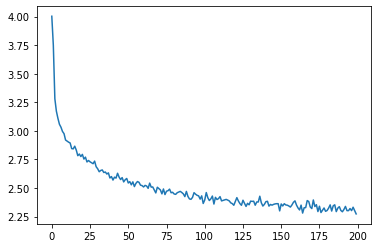

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)

## Text generation steps
Th eprocess of name generation is ,the network is given a letter and ask what the next one is, feed that in as the next letter, and repeat until the EOS token.
Steps:
*Create tensors for input category, starting letter, and empty hidden state
*Create a string output_name with the starting letter
*Up to a maximum output length,
*Feed the current letter to the network
*Get the next letter from highest output, and next hidden state
*If the letter is EOS, stop here
*If a regular letter, add to output_name and continue
*Return the final name

In [ ]:
max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

print("Italian:-")
samples('Italian', 'BPRT')
print("\nKorean:-")
samples('Korean', 'CMRS')
print("\nRussian:-")
samples('Russian', 'AJLN')
print("\nVietnamese:-")
samples('Vietnamese', 'LMT')

Italian:-
Baricha
Parichi
Rontili
Tontini

Korean:-
Chon
Man
Ron
Sho

Russian:-
Allinkov
Jakin
Lakin
Nakin

Vietnamese:-
Lan
Man
Than


## LSTM model for text generation

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# get characters from string printable
all_characters = string.printable
n_charcters=len(all_characters)
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers, drop_prob=0.5):
        super(LSTM, self).__init__()
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        self.embedding = nn.Embedding(input_size, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, hidden,cell):
        
        out = self.embedding(x)
        out, (hidden,cell) = self.lstm(out.unsqueeze(1), (hidden,cell))
        out = self.fc(out.reshape(out.shape[0],-1))
        return out,(hidden,cell)
        
        out = self.dropout(lstm_out)
        out = self.fc(out)
        out = self.sigmoid(out)
        
        out = out.view(batch_size, -1)
        out = out[:,-1]
        return out, hidden
    
    def init_hidden(self, batch_size):
        hidden=torch.zeros(self.num_layers,batch_size,self.hidden_size).to(device)
        cell =torch.zeros(self.num_layers,batch_size,self.hidden_size).to(device)
        return hidden,cell
def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)
  

          
    
 


## Training LSTM 

In [ ]:
lstm = LSTM(n_letters,n_letters,256,2,0.5) # hidden nodes are 256

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 13s (5000 5%) 2.0955
0m 27s (10000 10%) 2.3802
0m 41s (15000 15%) 2.5795
0m 55s (20000 20%) 2.8123
1m 9s (25000 25%) 2.3245
1m 23s (30000 30%) 3.1433
1m 36s (35000 35%) 2.9129
1m 50s (40000 40%) 1.0922
2m 3s (45000 45%) 2.0565
2m 17s (50000 50%) 1.6653
2m 30s (55000 55%) 2.2414
2m 44s (60000 60%) 2.3289
2m 57s (65000 65%) 2.2689
3m 11s (70000 70%) 2.4775
3m 24s (75000 75%) 1.5311
3m 37s (80000 80%) 1.6242
3m 51s (85000 85%) 3.2298
4m 4s (90000 90%) 1.9068
4m 18s (95000 95%) 2.1670
4m 32s (100000 100%) 2.3243


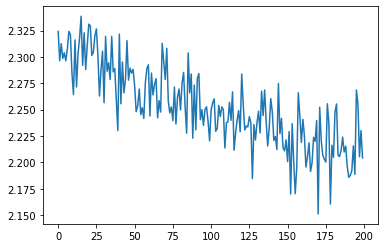

In [ ]:
plt.figure()
plt.plot(all_losses)

In [ ]:
lstm = LSTM(n_letters,n_letters,128,2,0.5) # hidde nnodes are 128

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 12s (5000 5%) 2.1189
0m 24s (10000 10%) 2.7177
0m 36s (15000 15%) 1.5591
0m 48s (20000 20%) 1.3971
1m 0s (25000 25%) 2.1455
1m 12s (30000 30%) 2.7191
1m 25s (35000 35%) 2.1228
1m 37s (40000 40%) 2.3320
1m 49s (45000 45%) 1.8218
2m 2s (50000 50%) 2.3762
2m 14s (55000 55%) 1.8309
2m 26s (60000 60%) 1.7290
2m 38s (65000 65%) 2.1160
2m 50s (70000 70%) 2.2297
3m 2s (75000 75%) 1.7931
3m 14s (80000 80%) 2.8070
3m 26s (85000 85%) 0.8474
3m 39s (90000 90%) 2.5864
3m 51s (95000 95%) 1.6435
4m 3s (100000 100%) 1.9644


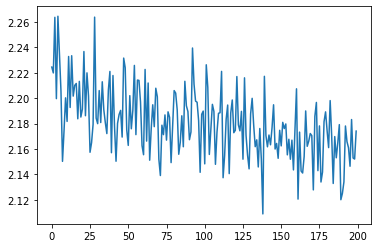

In [ ]:
plt.figure()
plt.plot(all_losses)

In [ ]:
max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

print("Italian:-")
samples('Italian', 'BPRT')
print("\nKorean:-")
samples('Korean', 'CMRS')
print("\nRussian:-")
samples('Russian', 'AJLN')
print("\nVietnamese:-")
samples('Vietnamese', 'LMT')

Italian:-
Bartoni
Pangalia
Romal
Tangali

Korean:-
Chon
Mon
Ro
Sho

Russian:-
Alamanov
Jandon
Limanov
Nakin

Vietnamese:-
La
Ma
Thang
